<a href="https://colab.research.google.com/github/ibenatar-96/statistical-rethinking-numpyro/blob/main/chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chapter 4 in Statistical Rethinking

In [22]:
!pip install -q numpyro arviz
!git clone https://github.com/fehiepsi/rethinking-numpyro.git

Cloning into 'rethinking-numpyro'...
remote: Enumerating objects: 1805, done.
remote: Counting objects: 100% (408/408), done.
remote: Compressing objects: 100% (249/249), done.
remote: Total 1805 (delta 209), reused 273 (delta 142), pack-reused 1397
Receiving objects: 100% (1805/1805), 158.83 MiB | 26.09 MiB/s, done.
Resolving deltas: 100% (1228/1228), done.


In [31]:
import os
import warnings

import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

In [5]:
# Code 4.1

pos = jnp.sum(dist.Uniform(-1, 1).sample(random.PRNGKey(0), (1000, 16)), -1)

array([[<Axes: >]], dtype=object)

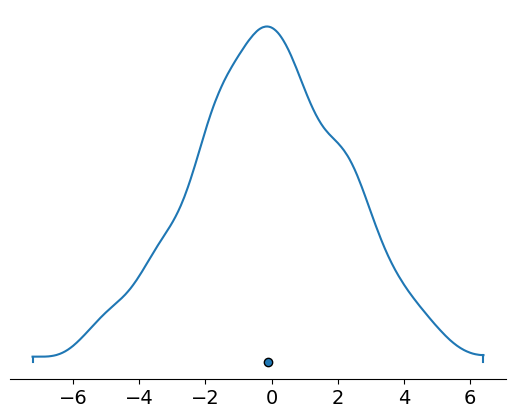

In [8]:
az.plot_density({"": pos}, hdi_prob=1)

In [9]:
# Code 4.2

jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (12,))) # samples 12 numbers between 1.0 and 1.1, each time multiplying the answer

Array(1.7294353, dtype=float32)

(1000, 12)


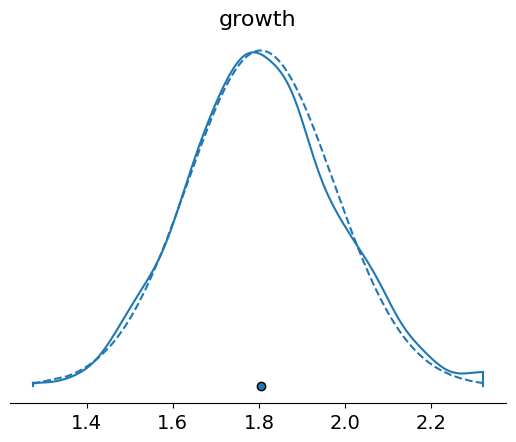

In [18]:
# Code 4.3

# Sample 1000 sets of 12 values from a uniform distribution [0, 0.1], this results in (1000,12) array
uniform_samples = dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (1000, 12))

# Add 1 to each sampled value
adjusted_samples = 1 + uniform_samples

# Compute the product of the 12 values in each of the 1000 sets (along the last axis), this results in a (1000,1) array
growth = jnp.prod(adjusted_samples, -1)

# Plot the density of the growth values
az.plot_density({"growth": growth}, hdi_prob=1)

# Sort the growth values
x = jnp.sort(growth)

# Plot a normal distribution curve over the sorted growth values
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")

# Show the plot
plt.show()

array([[<Axes: >]], dtype=object)

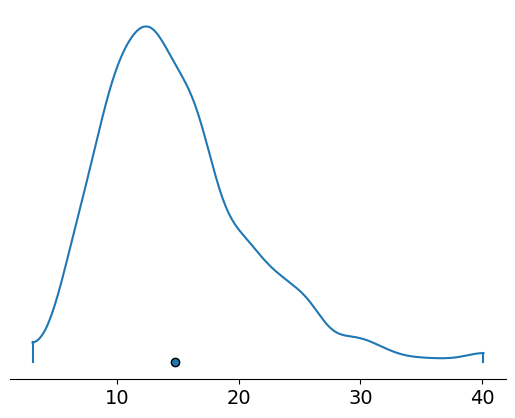

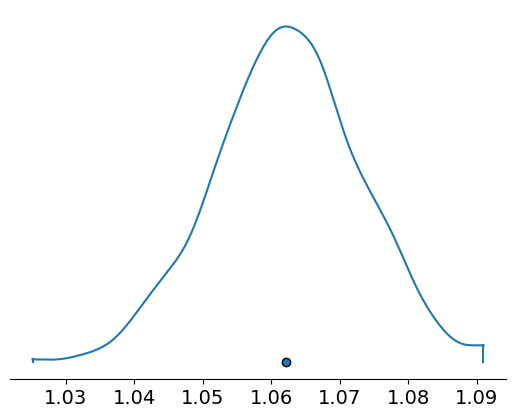

In [20]:
# Code 4.4

big = jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000, 12)), -1)
small = jnp.prod(1 + dist.Uniform(0, 0.01).sample(random.PRNGKey(0), (1000, 12)), -1)

az.plot_density({"": big}, hdi_prob=1)
az.plot_density({"": small}, hdi_prob=1)

In [24]:
# Code 4.7

Howell1 = pd.read_csv("rethinking-numpyro/data/Howell1.csv", sep=";")
d = Howell1

In [25]:
# Code 4.8

d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [26]:
# Code 4.9

print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       age     29.34     20.75     27.00      0.00     57.00    186.38      1.03
    height    138.26     27.60    148.59     90.81    170.18    218.68      1.06
      male      0.47      0.50      0.00      0.00      1.00    670.75      1.00
    weight     35.61     14.72     40.06     11.37     55.71    305.62      1.05



In [27]:
# Code 4.10

d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

In [28]:
# Code 4.11

d2 = d[d.age >= 18]

544
53.975
179.07


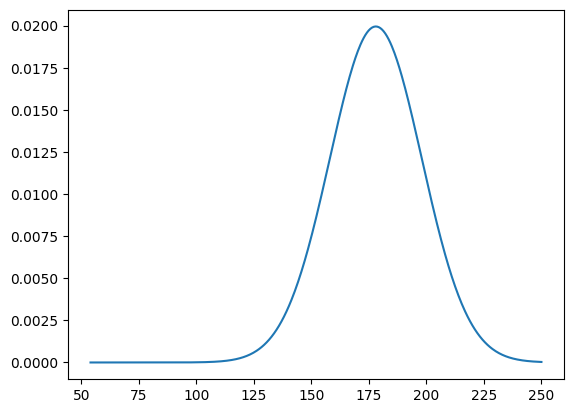

In [38]:
# Code 4.12

x = jnp.linspace(np.min(d.height), 250, d.height.shape[0])
y = d2.height
plt.plot(x, jnp.exp(dist.Normal(178, 20).log_prob(x)))
plt.show()